<a href="https://colab.research.google.com/github/RodrigoLima82/Estratificacao_Risco_Diabetes/blob/master/Estratificacao_de_Risco_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estratificando riscos usando registros eletrônicos de pacientes diabéticos

Autor: Rodrigo de Lima Oliveira

Referências:

[DSA] https://www.datascienceacademy.com.br/

In [2]:
!pip install scikit-plot

In [0]:
# Imports
import numpy as np
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from xgboost import XGBClassifier
import lightgbm as lgb
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix, plot_roc

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 14,6

In [15]:
# Importa os pacotes de algoritmos de redes neurais (Keras)
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
import keras.backend as K
from keras.optimizers import Adam
from keras import optimizers

Using TensorFlow backend.


In [4]:

from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [5]:
# Carregando os dados
df = pd.read_csv("diabetes.csv")

# Exibindo primeiros registros do dataset
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


Dicionário de Dados:
- 0- **encounter_id** - identificador único de um encontro do pesquisador com o paciente.
- 1- **patient_nbr** - identificador exclusivo de um paciente.
- 2- **race** - valores: Caucasian, Asian, African American, Hispanic e other.
- 3- **gender** - valores: male, female, and unknown/invalid.
- 4- **age** - agrupados em intervalos de 10 anos: (0, 10), (10, 20), ..., (90, 100).
- 5- **weight** - peso em libras.
- 6- **admission_type_id** - identificador inteiro correspondente a 9 valores distintos, por exemplo, "emergência, urgência, eletiva, recém-nascido e não disponível".
- 7- **discharge_disposition_id** - identificador inteiro correspondente a 29 valores distintos, por exemplo, "enviado para casa, expirou e não está disponível".
- 8- **admission_source_id** - identificador inteiro correspondente a 21 valores distintos, por exemplo, "encaminhamento médico, e transferência de um hospital".
- 9- **time_in_hospital** - número inteiro de dias entre a admissão e a alta,
- 10- **payer_code** - identificador inteiro correspondente a 23 valores distintos, por exemplo, Blue Cross / Blue Shield, Medicare e auto-pagamento".
- 11- **medical_specialty** - identificador inteiro de uma especialidade do médico admitidor, correspondente a 84 valores distintos, por exemplo, cardiologia, medicina interna, família / clínica geral e cirurgião".
- 12- **num_lab_procedures** - número de testes de laboratório realizados durante a consulta.
- 13- **num_procedures** - número de procedimentos (exceto testes de laboratório) realizados durante a consulta.
- 14- **num_medications** - número de medicamentos genéricos distintos administrados durante a consulta.
- 15- **number_outpatient** - número de consultas ambulatoriais do paciente no ano anterior a consulta.
- 16- **number_emergency** - número de visitas de emergência do paciente no ano anterior a consulta.
- 17- **number_inpatient** - número de visitas hospitalares do paciente no ano anterior a consulta.
- 18- **diag_1** - diagnóstico primário (codificado como três primeiros dígitos da CID9); 848 valores distintos.
- 19- **diag_2** - diagnóstico secundário (codificado como três primeiros dígitos da CID9); 923 valores distintos.
- 20- **diag_3** - diagnóstico secundário adicional (codificado como três primeiros dígitos da CID9); 954 valores distintos.
- 21- **number_diagnoses** - número de diagnósticos inseridos no sistema.
- 22- **max_glu_serum** - teste sérico de glicose que indica a faixa do resultado ou se o teste não foi realizado. Valores: > 200, > 300, normal e nenhum, se não for medido.
- 23- **A1Cresult** - teste A1c que indica o intervalo do resultado ou se o teste não foi realizado. Valores: > 8 (se o resultado for maior que 8%), > 7 (se o resultado for maior que 7%, porém menor que 8%), normal (se o resultado for inferior a 7%) e nenhum, se não for medido.

Na sequência temos os recursos de 24 a 46 para os nomes dos medicamentos genéricos:

metformina, repaglinida, nateglinida, clorpropamida, glimepirida, acetohexamida, glipizida, gliburida, tolbutamida, pioglitazona, rosiglitazona, acarbose, miglitol, troglitazona, insulazforamida, examide, sitaglagliptida, sitazagliptida , glipizida-metformina, glimepirida-pioglitazona, metformina-rosiglitazona e metformina-pioglitazona, 

Cada um desses recursos indica se o medicamento foi prescrito ou se houve uma alteração na dosagem. Valores: "up" se a dose foi aumentada durante a consulta. 

- 47- **change** - indica se houve alteração nos medicamentos para diabéticos (dosagem ou nome genérico). Valores: "change" e "no change".
- 48- **diabetesMed** - indica se houve algum medicamento diabético prescrito. Valores: "sim" e "não".
- 49- **readmitted** - readmitido, "Dias para readmissão hospitalar. Valores: <30 (se o paciente foi readmitido em menos de 30 dias), > 30 (se o paciente foi readmitido em mais de 30 dias) e No, para nenhum registro de readmissão. 

Nota: Códigos ICD-9 ou CID-9 (International Classification of Diseases ou Código Internacional de Doenças).

## Realizando Engenharia de Atributos

In [0]:
def feature_engineering(dados):

    # Removendo as 3 colunas com alto percentual de valores ausentes
    dados = dados.drop(['weight','payer_code','medical_specialty'], axis = 1)

    # Removemos os registros com baixo percentual de valores ausentes
    dados = dados[dados['race'] != '?']
    dados = dados[dados['diag_1'] != '?']
    dados = dados[dados['diag_2'] != '?']
    dados = dados[dados['diag_3'] != '?']
    dados = dados[dados['gender'] != 'Unknown/Invalid']

    # Removendoo variáveis com valores únicos
    dados = dados.loc[:, dados.nunique() != 1]

    # Ajustando a variável alvo
    # '0' significa que não foi readmitido
    # '1' significa que foi readmitido, não importa quantos dias após a alta
    dados['readmitted'] = dados['readmitted'].replace('>30', 1)
    dados['readmitted'] = dados['readmitted'].replace('<30', 1)
    dados['readmitted'] = dados['readmitted'].replace('NO', 0)

    # Recategorizamos 'idade' para que a população seja distribuída de maneira mais uniforme
    # Classificamos como faixa de 0-50 pacientes de até 50 anos
    dados['age'] = pd.Series(['[0-50)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'] else val 
                              for val in dados['age']], index = dados.index)

    # Acima de 80 anos ficam na faixa de 80-100
    dados['age'] = pd.Series(['[80-100)' if val in ['[80-90)', '[90-100)'] else val 
                              for val in dados['age']], index = dados.index)


    # A variável 'admission_type_id' contém 8 níveis
    # Reduziremos os níveis de 'admission_type_id' para duas categorias
    dados['admission_type_id'] = pd.Series(['Emergencia' if val == 1 else 'Outro' 
                                            for val in dados['admission_type_id']], index = dados.index)


    # A variável 'discharge_disposition_id' contém 26 níveis
    # Reduziremos os níveis de 'discharge_disposition_id' para duas categorias
    dados['discharge_disposition_id'] = pd.Series(['Casa' if val == 1 else 'Outro' 
                                                  for val in dados['discharge_disposition_id']], index = dados.index)


    # A variável 'admission_source_id' contém 17 níveis
    # # Reduziremos os níveis de 'admission_source_id' para três categorias
    dados['admission_source_id'] = pd.Series(['Sala_Emergencia' if val == 7 else 'Recomendacao' if val == 1 else 'Outro' 
                                                  for val in dados['admission_source_id']], index = dados.index)


    # Concatena 3 variáveis em um dataframe
    diagnostico = dados[['diag_1', 'diag_2', 'diag_3']]

    # Aplicamos a função comorbidade aos dados
    dados['comorbidade'] = diagnostico.apply(calcula_comorbidade, axis = 1)

    # Drop das variáveis individuais
    dados.drop(['diag_1','diag_2','diag_3'], axis = 1, inplace = True)
    
    # Removendo dataframe temporario
    del diagnostico

    # Lista com os nomes das variáveis de medicamentos (3 variáveis já tinham sido removidas)
    medicamentos = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                    'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
                    'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
                    'glimepiride-pioglitazone', 'metformin-pioglitazone']


    # Loop para ajustar o valor das variáveis de medicamentos
    for col in medicamentos:
        if col in dados.columns:
            colname = str(col) + 'temp'
            dados[colname] = dados[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)


    # Cria uma variável para receber a contagem por paciente
    dados['num_alt_dosagem_med'] = 0

    # Contagem de modificações na dosagem de medicamentos
    for col in medicamentos:
        if col in dados.columns:
            colname = str(col) + 'temp'
            dados['num_alt_dosagem_med'] = dados['num_alt_dosagem_med'] + dados[colname]
            del dados[colname]


    # Recoding das colunas de medicamentos
    for col in medicamentos:
        if col in dados.columns:
            dados[col] = dados[col].replace('No', 0)
            dados[col] = dados[col].replace('Steady', 1)
            dados[col] = dados[col].replace('Up', 1)
            dados[col] = dados[col].replace('Down', 1) 


    # Variável com a contagem de medicamentos por paciente
    dados['num_med'] = 0

    # Carregamos a nova variável
    for col in medicamentos:
        if col in dados.columns:
            dados['num_med'] = dados['num_med'] + dados[col]


    # Remove as colunas de medicamentos
    dados = dados.drop(columns = medicamentos)


    # Recoding de variáveis categóricas binárias
    dados['change'] = dados['change'].replace('Ch', 1)
    dados['change'] = dados['change'].replace('No', 0)
    dados['gender'] = dados['gender'].replace('Male', 1)
    dados['gender'] = dados['gender'].replace('Female', 0)
    dados['diabetesMed'] = dados['diabetesMed'].replace('Yes', 1)
    dados['diabetesMed'] = dados['diabetesMed'].replace('No', 0)


    # Recoding de variáveis categóricas (label encoding)
    dados['A1Cresult'] = dados['A1Cresult'].replace('>7', 1)
    dados['A1Cresult'] = dados['A1Cresult'].replace('>8', 1)
    dados['A1Cresult'] = dados['A1Cresult'].replace('Norm', 0)
    dados['A1Cresult'] = dados['A1Cresult'].replace('None', -99)
    dados['max_glu_serum'] = dados['max_glu_serum'].replace('>200', 1)
    dados['max_glu_serum'] = dados['max_glu_serum'].replace('>300', 1)
    dados['max_glu_serum'] = dados['max_glu_serum'].replace('Norm', 0)
    dados['max_glu_serum'] = dados['max_glu_serum'].replace('None', -99)


    # Removendo duplicidades por id de paciente, mantendo o primeiro registro
    dados = dados.drop_duplicates(subset = ['patient_nbr'], keep = 'first')


    # Remove as variáveis de ID
    dados.drop(['encounter_id', 'patient_nbr'], axis = 1, inplace = True)
    
    return dados

In [0]:
# Função que calcula a Comorbidade
def calcula_comorbidade(row):
    
    # Código 250 indica diabetes
    codigos_doenca_diabetes = "^[2][5][0]"
    
    # Códigos 39x (x = valor entre 0 e 9)
    # Códigos 4zx (z = valor entre 0 e 6 e x = valor entre 0 e 9)
    # Esses códigos indicam problemas circulatórios
    codigos_doenca_circulatorios = "^[3][9][0-9]|^[4][0-5][0-9]"
    
    # Inicializa variável de retorno
    valor = 0
    
    # Valor 0 indica que:
    # Diabetes E problemas circulatórios não foram detectados de forma simultânea no paciente
    if(not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1']))))) and
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2']))))) and 
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3'])))))) and (not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3'])))))):
        valor = 0
        
    # Valor 1 indica que:
    # Pelo menos um diagnóstico de diabetes E problemas circulatórios foram detectados de forma 
    # simultânea no paciente
    if(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3']))))) and (not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3'])))))): 
        valor = 1
        
    # Valor 2 indica que:
    # Diabetes E pelo menos um diagnóstico de problemas circulatórios foram detectados de forma 
    # simultânea no paciente
    if(not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1']))))) and
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2']))))) and 
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3'])))))) and (
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3']))))):
        valor = 2
        
    # Valor 3 indica que:
    # Pelo menos um diagnóstico de diabetes e pelo menos um diagnóstico de problemas circulatórios 
    # foram detectados de forma simultânea no paciente
    if(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3']))))) and (
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3']))))):
        valor = 3 
    
    return valor

## Preparando os dados para treinamento

In [0]:
# Funcao para balanceamento entre as classes
def balanceamento_classe(X, y):

    # Criamos o objeto SMOTE
    sm = SMOTE(random_state = 42)

    # Treinamos o balanceador SMOTE
    new_X, new_y = sm.fit_sample(X, y)   
    
    return new_X, new_y

In [9]:
# Aplicando engenharia de atributos no dataset
train = feature_engineering(df)

# Vamos armazenar 'readmitted' no rótulo (y) e o restante das colunas em X
y = train['readmitted']
X = train.drop(['readmitted'], axis = 1)

# Vamos criar variáveis dummy para variáveis categóricas
X = pd.get_dummies(X)

# Cria o padronizador
scaler = StandardScaler()

# Padronizando os dados
X = scaler.fit_transform(X)

# Aplicar o balanceamento de classes usando SMOTE
new_X, new_y = balanceamento_classe(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Executando vários modelos de classificação

In [10]:
# Definindo os valores para o número de folds
num_folds = 10
seed = 42

# Preparando a lista de modelos
modelos = []
modelos.append(('LR',  LogisticRegression()))
modelos.append(('RF',  RandomForestClassifier()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('DT',  DecisionTreeClassifier()))
modelos.append(('NB',  GaussianNB()))
modelos.append(('XGB', XGBClassifier()))
modelos.append(('LGB', lgb.LGBMClassifier()))

# Avaliando cada modelo em um loop
resultados = []
nomes      = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds, shuffle=True, random_state = seed)
    cv_results = cross_val_score(modelo, X, y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.622405 (0.005452)
RF: 0.611229 (0.006156)
KNN: 0.577875 (0.006208)
DT: 0.543895 (0.006081)
NB: 0.613181 (0.004410)
XGB: 0.625290 (0.004777)
LGB: 0.629399 (0.004522)


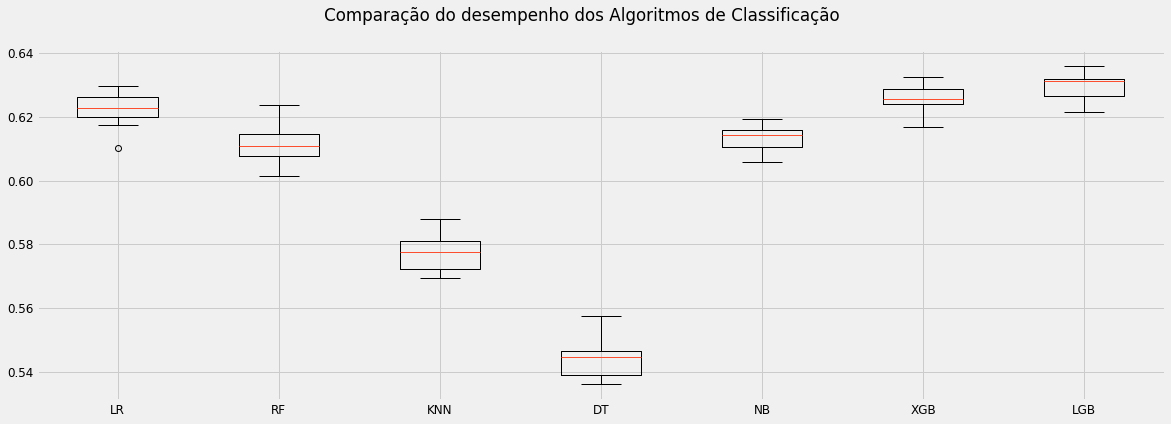

In [11]:
# Boxplot para comparar os algoritmos
fig = plt.figure(figsize = (18, 6))

fig.suptitle('Comparação do desempenho dos Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

## Realizando Otimização de Hyperparametros no melhor modelo

In [46]:
def plot_prediction_distribution(y_true, y_pred, ax):
    df = pd.DataFrame({'prediction': y_pred, 'original': y_true})    
    sns.distplot(df[df['original'] == 0]['prediction'], label='negative', ax=ax)
    sns.distplot(df[df['original'] == 1]['prediction'], label='positive', ax=ax)
    ax.legend(prop={'size': 16}, title = 'Labels')
    
# Definindo os valores para o número de folds
N_SPLITS  = 3
SEED      = 0

TRAIN_PARAMS = {
                'num_boosting_rounds': 1000000,
                'early_stopping_rounds' : 4000
               }

MODEL_PARAMS = {
                 'boosting_type'           : 'gbdt',
                 'metric'                  : 'auc',
                 'objective'               : 'binary',
                 'learning_rate'           : 0.01,
                 'max_depth'               : -1,
                 'min_data_in_leaf'        : 260,
                 'min_sum_hessian_in_leaf' : 10.0,
                 'num_leaves'              : 10,
                 'scale_pos_weight'        : 0.51,
                 #'is_unbalance'            : True,
                 'verbosity'               : 1
               }

# Define o peso para as classes
#pesos_classes = {0:0.49, 1:0.51}

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
oof = np.zeros(len(new_X))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(new_X, new_y)):

    print("Fold {}".format(fold_))

    trn_data = lgb.Dataset(new_X[trn_idx], label=new_y[trn_idx])
    val_data = lgb.Dataset(new_X[val_idx], label=new_y[val_idx])

    clf = lgb.train(MODEL_PARAMS, 
                    trn_data, 
                    TRAIN_PARAMS['num_boosting_rounds'], 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 5000, 
                    early_stopping_rounds = TRAIN_PARAMS['early_stopping_rounds'])

    oof[val_idx] = clf.predict(new_X[val_idx], num_iteration=clf.best_iteration)            

Fold 0
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.790851	valid_1's auc: 0.756268
Early stopping, best iteration is:
[3561]	training's auc: 0.783187	valid_1's auc: 0.756801
Fold 1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.791655	valid_1's auc: 0.758076
Early stopping, best iteration is:
[3527]	training's auc: 0.783199	valid_1's auc: 0.758317
Fold 2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.793335	valid_1's auc: 0.753677
Early stopping, best iteration is:
[3345]	training's auc: 0.783349	valid_1's auc: 0.754441


In [47]:
# Cria e imprime a matriz de confusão
conf_matriz_lr = confusion_matrix(new_y, oof > 0.5)

# Calcula o total 
total1 = sum(sum(conf_matriz_lr))

# Calcula a acurácia
accuracy_lr = (conf_matriz_lr[0,0] + conf_matriz_lr[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_lr = conf_matriz_lr[0,0] / (conf_matriz_lr[0,0] + conf_matriz_lr[0,1])
sensi_lr = conf_matriz_lr[1,1] / (conf_matriz_lr[1,0] + conf_matriz_lr[1,1])

# Calcula ROC AUC
roc_auc_oof = roc_auc_score(new_y, oof)

# Print
print('ROC_AUC        : ', roc_auc_oof)
print('Acurácia       : ', accuracy_lr)
print('Sensibilidade  : ', sensi_lr)
print('Especificidade : ', speci_lr)
print('\n')

# Relatório de Classificação
print(classification_report(new_y, oof > 0.5, target_names = ['Não', 'Sim']))

ROC_AUC        :  0.7565017707477296
Acurácia       :  0.6699283250568752
Sensibilidade  :  0.3595244502067076
Especificidade :  0.9803321999070428


              precision    recall  f1-score   support

         Não       0.60      0.98      0.75     40879
         Sim       0.95      0.36      0.52     40879

    accuracy                           0.67     81758
   macro avg       0.78      0.67      0.63     81758
weighted avg       0.78      0.67      0.63     81758



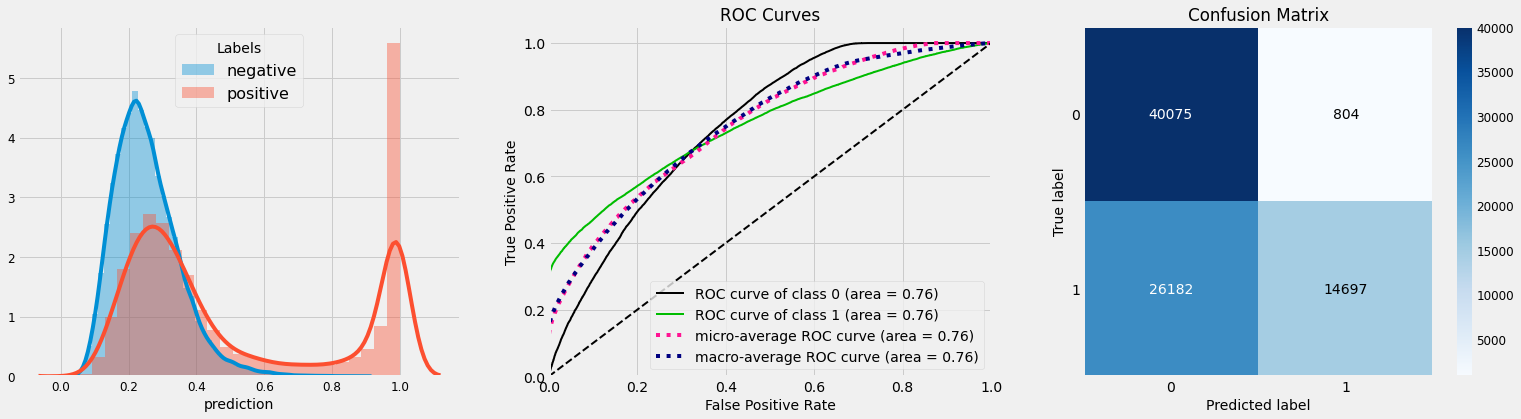

In [48]:


preds = pd.DataFrame(oof, columns=['pos_preds'])
preds['neg_preds'] = 1.0 - preds['pos_preds']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 6))

plot_prediction_distribution(new_y, preds['pos_preds'], ax=ax1);

plot_roc(new_y, preds[['neg_preds','pos_preds']], ax=ax2);

plot_confusion_matrix(new_y, oof > 0.5, ax=ax3);

## Modelagem com Deep Learning

In [105]:
# Aplicando engenharia de atributos no dataset
train = feature_engineering(df)

# Vamos armazenar 'readmitted' no rótulo (y) e o restante das colunas em X
y = train['readmitted']
X = train.drop(['readmitted'], axis = 1)

# Vamos criar variáveis dummy para variáveis categóricas
X = pd.get_dummies(X)

# Split dos dados
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, y, test_size = .2, random_state = 0, stratify = y)

# Cria o padronizador
scaler = StandardScaler()

# Padronizando os dados
X_treino_scaled = scaler.fit_transform(X_treino)

# Nos dados de teste, aplicamos apenas o transform()
X_teste_scaled = scaler.transform(X_teste)

# Aplicar o balanceamento de classes usando SMOTE
new_X, new_y, features_columns = balanceamento_classe(X_treino_scaled, Y_treino)

# Define o peso para as classes
pesos_classes = {0:0.49, 1:0.51}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [108]:
X.head()

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,comorbidade,num_alt_dosagem_med,num_med,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,age_[0-50),age_[50-60),age_[60-70),age_[70-80),age_[80-100),admission_type_id_Emergencia,admission_type_id_Outro,discharge_disposition_id_Casa,discharge_disposition_id_Outro,admission_source_id_Outro,admission_source_id_Recomendacao,admission_source_id_Sala_Emergencia
1,0,3,59,0,18,0,0,0,9,-99,-99,1,1,1,1,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
2,0,2,11,5,13,2,0,1,6,-99,-99,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1
3,1,2,44,1,16,0,0,0,7,-99,-99,1,1,3,1,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
4,1,1,51,0,8,0,0,0,5,-99,-99,1,1,1,0,2,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
5,1,3,31,6,16,0,0,0,9,-99,-99,0,1,3,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0


In [113]:
# Cria o modelo
modelo_dl = Sequential()

# Adiciona as camadas ocultas
modelo_dl.add(Dense(units = 26, kernel_initializer = 'uniform', activation = 'relu', input_dim = 33))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

"""
modelo_dl.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 33))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'tanh'))
modelo_dl.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
"""

# Compila o modelo
modelo_dl.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Treinamento do modelo
modelo_dl.fit(new_X, new_y, batch_size = 50, epochs = 100, class_weight = pesos_classes)

Epoch 1/100
65406/65406 [==============================] - 2s 29us/step - loss: 0.3345 - accuracy: 0.5873
Epoch 2/100
65406/65406 [==============================] - 2s 26us/step - loss: 0.3311 - accuracy: 0.6001
Epoch 3/100
65406/65406 [==============================] - 2s 26us/step - loss: 0.3294 - accuracy: 0.6042
Epoch 4/100
65406/65406 [==============================] - 2s 25us/step - loss: 0.3284 - accuracy: 0.6062
Epoch 5/100
65406/65406 [==============================] - 2s 25us/step - loss: 0.3274 - accuracy: 0.6095
Epoch 6/100
65406/65406 [==============================] - 2s 29us/step - loss: 0.3265 - accuracy: 0.6103
Epoch 7/100
65406/65406 [==============================] - 2s 27us/step - loss: 0.3258 - accuracy: 0.6143
Epoch 8/100
65406/65406 [==============================] - 2s 28us/step - loss: 0.3251 - accuracy: 0.6149
Epoch 9/100
65406/65406 [==============================] - 2s 27us/step - loss: 0.3246 - accuracy: 0.6162
Epoch 10/100
65406/65406 [====================

KeyboardInterrupt: ignored

In [111]:
# Realiza as previsões
dl_Y_pred = modelo_dl.predict(X_teste_scaled)

# Converte as probabilidades em classe
dl_t_Y_pred = (dl_Y_pred > 0.5)

# Agora convertemos os valores booleanos em classe binária, 0 ou 1
Y_dl_pred = np.where(dl_t_Y_pred == 'True', 1, dl_t_Y_pred)

# Cria e imprime a matriz de confusão
conf_matriz_dl = confusion_matrix(Y_teste, Y_dl_pred)
print(conf_matriz_dl)

# Calcula o total 
total1 = sum(sum(conf_matriz_dl))

# Calcula a acurácia
accuracy_dl = (conf_matriz_dl[0,0] + conf_matriz_dl[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_dl = conf_matriz_dl[0,0] / (conf_matriz_dl[0,0] + conf_matriz_dl[0,1])
sensi_dl = conf_matriz_dl[1,1] / (conf_matriz_dl[1,0] + conf_matriz_dl[1,1])

# Print
print('\nAcurácia : ', accuracy_dl)
print('Sensibilidade :', sensi_dl)
print('Especificidade :', speci_dl)


[[4507 3669]
 [2225 3325]]

Acurácia :  0.5705959492933119
Sensibilidade : 0.5990990990990991
Especificidade : 0.551247553816047


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [114]:
# Cria o modelo
modelo_dl = Sequential()

# Adiciona as camadas ocultas
modelo_dl.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 33))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
modelo_dl.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'tanh'))
modelo_dl.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compila o modelo
modelo_dl.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Treinamento do modelo
modelo_dl.fit(new_X, new_y, batch_size = 1024, epochs = 100, class_weight = pesos_classes)

Epoch 1/100
65406/65406 [==============================] - 1s 9us/step - loss: 0.3370 - accuracy: 0.5764
Epoch 2/100
65406/65406 [==============================] - 0s 7us/step - loss: 0.3323 - accuracy: 0.5954
Epoch 3/100
65406/65406 [==============================] - 0s 7us/step - loss: 0.3310 - accuracy: 0.5985
Epoch 4/100
65406/65406 [==============================] - 0s 7us/step - loss: 0.3300 - accuracy: 0.6020
Epoch 5/100
65406/65406 [==============================] - 0s 6us/step - loss: 0.3290 - accuracy: 0.6047
Epoch 6/100
65406/65406 [==============================] - 0s 6us/step - loss: 0.3286 - accuracy: 0.6070
Epoch 7/100
65406/65406 [==============================] - 0s 6us/step - loss: 0.3280 - accuracy: 0.6068
Epoch 8/100
65406/65406 [==============================] - 0s 6us/step - loss: 0.3271 - accuracy: 0.6097
Epoch 9/100
65406/65406 [==============================] - 0s 6us/step - loss: 0.3268 - accuracy: 0.6102
Epoch 10/100
65406/65406 [=============================

In [115]:
# Realiza as previsões
dl_Y_pred = modelo_dl.predict(X_teste_scaled)

# Converte as probabilidades em classe
dl_t_Y_pred = (dl_Y_pred > 0.5)

# Agora convertemos os valores booleanos em classe binária, 0 ou 1
Y_dl_pred = np.where(dl_t_Y_pred == 'True', 1, dl_t_Y_pred)

# Cria e imprime a matriz de confusão
conf_matriz_dl = confusion_matrix(Y_teste, Y_dl_pred)
print(conf_matriz_dl)

# Calcula o total 
total1 = sum(sum(conf_matriz_dl))

# Calcula a acurácia
accuracy_dl = (conf_matriz_dl[0,0] + conf_matriz_dl[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_dl = conf_matriz_dl[0,0] / (conf_matriz_dl[0,0] + conf_matriz_dl[0,1])
sensi_dl = conf_matriz_dl[1,1] / (conf_matriz_dl[1,0] + conf_matriz_dl[1,1])

# Print
print('\nAcurácia : ', accuracy_dl)
print('Sensibilidade :', sensi_dl)
print('Especificidade :', speci_dl)


[[4820 3356]
 [2669 2881]]

Acurácia :  0.5610520180679003
Sensibilidade : 0.5190990990990991
Especificidade : 0.5895303326810176


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [0]:
from keras.regularizers import l2,l1, l1_l2

def get_nn(x_tr,y_tr,x_val,y_val,shape):
    K.clear_session()
    inp = Input(shape = (x_tr.shape[1],))
    
    x = Dense(128, input_dim=X.shape[1], activation='tanh')(inp)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='relu', bias_regularizer=l1_l2(l1=0.0001,l2=0.0001))(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='tanh')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)

    out = Dense(1, activation='sigmoid')(x)
    model = Model(inp,out)
    
    model.compile(optimizer = optimizers.adam(lr = 0.01, decay = 0.01),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
     
    # Definição do batch size
    bsz = 1024
    
    # Define o peso para as classes
    class_weight = {0:0.47, 1:0.53}

    model.fit(x_tr, y_tr,
              epochs = 250, 
              batch_size=bsz,
              class_weight = class_weight,
              verbose=1,              
              shuffle=True)
    
    #model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    
    # Converte as probabilidades em classe
    dl_t_Y_pred = (y_pred > 0.5)
    
    # Agora convertemos os valores booleanos em classe binária, 0 ou 1
    Y_dl_pred = np.where(dl_t_Y_pred == 'True', 1, dl_t_Y_pred)

    # Cria e imprime a matriz de confusão
    conf_matriz_dl = confusion_matrix(y_valid, Y_dl_pred)

    # Calcula o total 
    total1 = sum(sum(conf_matriz_dl))

    # Calcula a acurácia
    accuracy_dl = (conf_matriz_dl[0,0] + conf_matriz_dl[1,1]) / total1

    return model, accuracy_dl

In [0]:
%%time

loop = 2
fold = 6

#oof_nn = np.zeros()
models_nn = []
score_nn = []

for k in range(loop):
    
    kfold = KFold(fold, random_state = 123 + k, shuffle = True)
    
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(new_X, new_y)):
        print("---------------------------")
        print(f'Loop {k+1}/{loop}' + f' Fold {k_fold+1}/{fold}')
        print("---------------------------")
        
        tr_x, tr_y = new_X[tr_inds], new_y[tr_inds]
        val_x, val_y = new_X[val_inds], new_y[val_inds]
        
        # Train NN
        nn, score = get_nn(tr_x, tr_y, val_x, val_y, shape=val_x.shape[0])
        models_nn.append(nn)
        
        print("the %d fold score (NN) is %f"%((k_fold+1), score))
        score_nn.append(score)
        
        #Predict OOF
        #oof_nn[k, val_inds, :] = nn.predict(val_x)
        
    print("PARCIAL: mean score (NN) is %f"%np.mean(score_nn))

print("FINAL mean score (NN) is %f"%np.mean(score_nn))    

---------------------------
Loop 1/2 Fold 1/6
---------------------------
Epoch 1/250
54505/54505 [==============================] - 3s 55us/step - loss: 0.3691 - accuracy: 0.5554
Epoch 2/250
54505/54505 [==============================] - 2s 45us/step - loss: 0.3326 - accuracy: 0.5871
Epoch 3/250
54505/54505 [==============================] - 2s 45us/step - loss: 0.3301 - accuracy: 0.5959
Epoch 4/250
54505/54505 [==============================] - 3s 46us/step - loss: 0.3286 - accuracy: 0.6005
Epoch 5/250
54505/54505 [==============================] - 2s 46us/step - loss: 0.3275 - accuracy: 0.6056
Epoch 6/250
54505/54505 [==============================] - 3s 47us/step - loss: 0.3259 - accuracy: 0.6094
Epoch 7/250
54505/54505 [==============================] - 3s 46us/step - loss: 0.3248 - accuracy: 0.6107
Epoch 8/250
54505/54505 [==============================] - 3s 46us/step - loss: 0.3235 - accuracy: 0.6153
Epoch 9/250
54505/54505 [==============================] - 2s 45us/step - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


the 1 fold score (NN) is 0.634162
---------------------------
Loop 1/2 Fold 2/6
---------------------------
Epoch 1/250
54505/54505 [==============================] - 3s 52us/step - loss: 0.3562 - accuracy: 0.5664
Epoch 2/250
54505/54505 [==============================] - 2s 40us/step - loss: 0.3316 - accuracy: 0.5906
Epoch 3/250
54505/54505 [==============================] - 2s 40us/step - loss: 0.3292 - accuracy: 0.6003
Epoch 4/250
54505/54505 [==============================] - 2s 40us/step - loss: 0.3276 - accuracy: 0.6071
Epoch 5/250
54505/54505 [==============================] - 2s 39us/step - loss: 0.3261 - accuracy: 0.6085
Epoch 6/250
54505/54505 [==============================] - 2s 40us/step - loss: 0.3243 - accuracy: 0.6124
Epoch 7/250
54505/54505 [==============================] - 2s 39us/step - loss: 0.3230 - accuracy: 0.6156
Epoch 8/250
54505/54505 [==============================] - 2s 39us/step - loss: 0.3219 - accuracy: 0.6201
Epoch 9/250
54505/54505 [===================

In [0]:
def predict(x_te, models_nn):
    
    model_num_nn = len(models_nn)

    for k,m in enumerate(models_nn):
        if k==0:
            y_pred_nn = m.predict(x_te, batch_size=1024)
        else:
            y_pred_nn += m.predict(x_te, batch_size=1024)
            
    y_pred_nn = y_pred_nn / model_num_nn
    
    return y_pred_nn

In [123]:
# Realiza as previsões
dl_Y_pred = predict(X_teste_scaled, models_nn)

# Converte as probabilidades em classe
dl_t_Y_pred = (dl_Y_pred > 0.5)

# Agora convertemos os valores booleanos em classe binária, 0 ou 1
Y_dl_pred = np.where(dl_t_Y_pred == 'True', 1, dl_t_Y_pred)

# Cria e imprime a matriz de confusão
conf_matriz_dl = confusion_matrix(Y_teste, Y_dl_pred)
print(conf_matriz_dl)

# Calcula o total 
total1 = sum(sum(conf_matriz_dl))

# Calcula a acurácia
accuracy_dl = (conf_matriz_dl[0,0] + conf_matriz_dl[1,1]) / total1
    
# Calcula especificidade e sensibilidade
speci_dl = conf_matriz_dl[0,0] / (conf_matriz_dl[0,0] + conf_matriz_dl[0,1])
sensi_dl = conf_matriz_dl[1,1] / (conf_matriz_dl[1,0] + conf_matriz_dl[1,1])

# Print
print('\nAcurácia : ', accuracy_dl)
print('Sensibilidade :', sensi_dl)
print('Especificidade :', speci_dl)


[[4680 3496]
 [2335 3215]]

Acurácia :  0.5751857788139297
Sensibilidade : 0.5792792792792792
Especificidade : 0.5724070450097848


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


## Estratificação de Risco

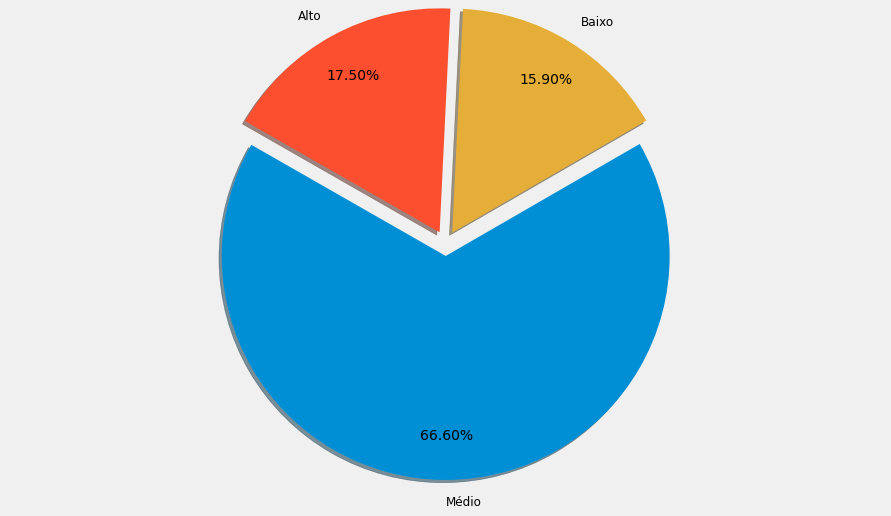

In [0]:
# Função para estratificar o risco
def classifica_risco(row):
    if row[0] <= 0.3 : return 'Baixo'
    if row[0] >= 0.7 : return 'Alto'
    return 'Médio'

# Criando um novo dataset com as previsões
df_proba = pd.DataFrame(oof, columns = ['Probabilidade'])

# Dataframe para o risco estratificado
df_risco = pd.DataFrame()

# Agora carregamos o dataframe
df_risco['Risco'] = df_proba.apply(classifica_risco, axis = 1)

# Vamos separar em percentual
percentual = round(df_risco.Risco.value_counts() / len(df_risco.index) * 100, 1)

# Legenda para o gráfico
sub = ['Médio', 'Alto', 'Baixo']

# Plot
plt.axis("equal")
plt.pie(percentual , 
        labels = sub, 
        radius = 1.6,
        autopct = '%1.2f%%',
        explode = [0.09,0.09,0.09],
        startangle = 30,
        shadow = True,
        counterclock = False,
        pctdistance = 0.8)

plt.show()